### Importação de bibliotecas e conexão com site 

In [4]:
import os
import numpy as np
import rasterio
from rasterio.mask import mask
import openeo
import json
import time
from datetime import datetime, timedelta
import requests
import subprocess
import os
import json
import openeo
from oauthlib.oauth2 import BackendApplicationClient
from requests_oauthlib import OAuth2Session
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from pathlib import Path
import zipfile
import shutil
import xarray as xr
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import datetime

In [ ]:
# Carregando o arquivo GeoJSON
geojson_path = "study_area.geojson"   # Criei um arquivo geojson da minha região de interesse através do QGIS. obs. exportar em EPSG 4326
# geojson_path = "/work/projetos/projeto-sophia-agro/sentinel2_10m/aquicultura_2_study_area.geojson"
with open(geojson_path) as f:
    geojson = json.load(f)

In [3]:
# Extraindo a geometria do GeoJSON
geom = geojson['features'][0]['geometry']

## SENTINEL 3 - Sea Surface Temperature

A obtenção do SST não é pelo caminho anterior. O acesso é pelo eumetsat:  
https://usc.tools.eumetsat.int/docs/eumdac/v3.0.0/eumdac.html

In [4]:
from eumdac.token import AccessToken
from eumdac.datastore import DataStore

In [ ]:
#https://usc.tools.eumetsat.int/docs/eumdac/v3.0.0/eumdac.html#
 
#https://api.eumetsat.int/api-key/#

import os
from dotenv import load_dotenv
from sentinelhub import DataStore, AccessToken

# carrega as variáveis do arquivo .env
load_dotenv()

# essa é uma dica de segurança para armazenar suas credenciais. Inseri no .env. Aqui, você deve mudar ao criar login 
# e gerar suas próprias credenciais no link acima
consumer_key = os.getenv('CONSUMER_KEY')
consumer_secret = os.getenv('CONSUMER_SECRET')

credentials = (consumer_key, consumer_secret)
token = AccessToken(credentials)
datastore = DataStore(token)
for collection in datastore.collections:
    print(f"{collection} - {collection.title}")

EO:EUM:DAT:METOP:GLB-SST-NC - Global L3C AVHRR Sea Surface Temperature (GHRSST) - Metop
EO:EUM:DAT:MSG:CLM-IODC - Cloud Mask - MSG - Indian Ocean
EO:EUM:DAT:MSG:CLM - Cloud Mask - MSG - 0 degree
EO:EUM:DAT:0142 - Poseidon-4 Level 2P Wind/Wave Products Low Resolution in NRT - Sentinel-6
EO:EUM:DAT:0143 - Poseidon-4 Level 3 Wind/Wave Products Low Resolution in NRT - Sentinel-6
EO:EUM:DAT:0374 - Commercial Radio Occultation Level 1B data - Multimission
EO:EUM:DAT:0406 - SRAL Level 1B - Sentinel-3
EO:EUM:DAT:0407 - OLCI Level 2 Ocean Colour Full Resolution - Sentinel-3
EO:EUM:DAT:0408 - OLCI Level 2 Ocean Colour Reduced Resolution - Sentinel-3
EO:EUM:DAT:0409 - OLCI Level 1B Full Resolution - Sentinel-3
EO:EUM:DAT:0410 - OLCI Level 1B Reduced Resolution - Sentinel-3
EO:EUM:DAT:0411 - SLSTR Level 1B Radiances and Brightness Temperatures - Sentinel-3
EO:EUM:DAT:0412 - SLSTR Level 2 Sea Surface Temperature (SST) - Sentinel-3
EO:EUM:DAT:0413 - SRAL Level 1A Unpacked L0 Complex echos - Sentinel

In [6]:
# Seleciono a coleção referente aos dados de temperatura de superfície da água
collection_id = 'EO:EUM:DAT:0412'
selected_collection = datastore.get_collection(collection_id)

In [7]:
print(selected_collection)
print(selected_collection.title)
print(selected_collection.abstract)

EO:EUM:DAT:0412


SLSTR Level 2 Sea Surface Temperature (SST) - Sentinel-3
SLSTR SST has a spatial resolution of 1km at nadir. Skin Sea Surface Temperature following the GHRSST L2P GDS2 format specification, see https://www.ghrsst.org/ . - All Sentinel-3 NRT products are available at pick-up point in less than 3h - All Sentinel-3 Non Time Critical (NTC) products are available at pick-up point in less than 30 days. Sentinel-3 is part of a series of Sentinel satellites, under the umbrella of the EU Copernicus programme.


In [ ]:

# Trecho adaptado com base no script do gitlab do eumetsat: 
# https://gitlab.eumetsat.int/eumetlab/oceans/ocean-training/sensors/learn-slstr/-/blob/main/2_SLSTR_advanced/2_1_SLSTR_advanced_data_access_eumdac.ipynb

# carrego o GeoJSON da minha região de estudo
gdf = gpd.read_file("study_area.geojson")

roi_geojson = geojson['features'][0]['geometry']['coordinates'][0]  # aqui, vou extrair as coordenadas para buscar apenas dados do SST que passam pela região de interesse

roi = roi_geojson[0]

if gdf.crs != "EPSG:4326": # converto para EPSG 4326 caso não esteja nesse sistema de referência de coordenadas
    gdf = gdf.to_crs("EPSG:4326")

selected_collection = datastore.get_collection(collection_id)
start = datetime.datetime(2025, 1, 23)
end = datetime.datetime(2025, 1, 24)

# formatação correta das coordenadas para a consulta WKT
polygon_str = ','.join(["{} {}".format(*coord) for coord in roi])
print(polygon_str) 

products = selected_collection.search(  # aqui, filtro apenas dados que passam pela região de estudo, tal como as datas de interesse
    geo=f'POLYGON(({polygon_str}))',
    dtstart=start, 
    dtend=end
)

for product in products:
    print(product)

# Como output, verei os arquivos em formato .SEN3

-50.0628800303096 -21.181697812853134,-50.02773313542511 -21.181518948248122,-50.026719569330055 -21.2093622050947,-50.062611733402086 -21.208944854349674,-50.0628800303096 -21.181697812853134
S3A_SL_2_WST____20250123T115244_20250123T133343_20250124T174724_6059_121_365______MAR_O_NT_003.SEN3
S3B_SL_2_WST____20250123T111352_20250123T125451_20250124T174523_6059_102_222______MAR_O_NT_003.SEN3
S3A_SL_2_WST____20250123T014648_20250123T032748_20250124T080053_6059_121_359______MAR_O_NT_003.SEN3
S3B_SL_2_WST____20250123T010757_20250123T024856_20250124T080407_6059_102_216______MAR_O_NT_003.SEN3


### Qual arquivo .SEN3 vou processar?

Para a escolha de qual arquivo processar, é importante entender a nomenclatura.  
**Façamos a decomposição:**  
**S3B_SL_2_WST____[timestamps]_[outros identificadores].SEN3**

Explicação da Nomenclatura de Arquivos Sentinel-3

* **S3B**: Satélite Sentinel-3B  
* **SL**: Nível de processamento (SL = Level-2)  
* **2**: Número da versão de processamento  
* **WST**: Tipo de produto (Water Surface Temperature)  
* **20250421T125154**: Data e hora de início da aquisição (21-04-2025 12:51:54 UTC) - Momento em que o satélite começou a capturar dados para esta cena específica  
* **20250421T125454**: Data e hora do fim da aquisição (21-04-2025 12:54:54 UTC) - Momento em que o satélite terminou a captura de dados para esta cena  
* **20250421T143300**: Data e hora do processamento (21-04-2025 14:33:00 UTC)  
* **0179**: Duração da aquisição em segundos (1 minuto e 79 segundos)  
* **105**: Ciclo orbital  
* **323**: Número da órbita relativa  
* **3240**: ID do frame  
* **MAR**: Centro de processamento (Marine)  
* **O**: Tipo de geração (O = Operational)  
* **NR**: Tipo de temporalidade do produto (NR = Near Real-time)  
* **003**: Número da versão de coleção  
* **.SEN3**: Extensão do arquivo/diretório para produtos Sentinel-3

Observação:  

**Existem dois tipos de produtos:**

NR (Near Real-time): produtos disponibilizados rapidamente, com processamento menos rigoroso  
NT (Non-Time-Critical): produtos com processamento mais completo, disponibilizados com maior atraso  

In [8]:
# atribua à variável product_list o arquivo selecionado
product_list = "S3B_SL_2_WST____20250123T010757_20250123T024856_20250124T080407_6059_102_216______MAR_O_NT_003.SEN3"
selected_product = datastore.get_product(product_id=product_list, collection_id=collection_id)

In [ ]:
download_dir = "./Sentinel_3_SST" # aqui, defini o caminho para guardar o meu .SEN3

# importante: ao fazer o download, o arquivo estará no formato zip
with selected_product.open() as fsrc, open(os.path.join(download_dir, fsrc.name), mode='wb') as fdst:
    print(f'Downloading {fsrc.name}')
    shutil.copyfileobj(fsrc, fdst)
    print(f'Download of product {fsrc.name} finished.')

Download of product S3B_SL_2_WST____20250123T010757_20250123T024856_20250124T080407_6059_102_216______MAR_O_NT_003.SEN3.zip finished.


In [13]:
# Nesse trecho, irei "deszipar" o arquivo

with zipfile.ZipFile(fdst.name, 'r') as zip_ref:
    for file in zip_ref.namelist():
        if file.startswith(str(selected_product)):
            zip_ref.extract(file, download_dir)
    print(f'Unzipping of product {selected_product} finished.')
os.remove(fdst.name)

Unzipping of product S3B_SL_2_WST____20250123T010757_20250123T024856_20250124T080407_6059_102_216______MAR_O_NT_003.SEN3 finished.


Para manter a eficiência de armazenamento, especialmente para produtos com grande cobertura espacial, é comum que o produto não armazene latitude e longitude como coordenadas, mas  sim índices da grade (grid indices) do conjunto de dados NetCDF. Isso é muito comum em dados de sensoriamento remoto e particularmente em produtos oceanográficos como os do Sentinel-3.  

O arquivo NetCDF armazena dados em uma estrutura de grade regular, onde:

ni representa os índices ao longo do eixo x (geralmente associado à longitude)
nj representa os índices ao longo do eixo y (geralmente associado à latitude)

O script abaixo serve para verificar essa configuração

In [ ]:
gdf = gpd.read_file("study_area.geojson")

ds = xr.open_dataset("./Sentinel_3_SST/S3B_SL_2_WST____20250123T010757_20250123T024856_20250124T080407_6059_102_216______MAR_O_NT_003.SEN3/20250123010757-MAR-L2P_GHRSST-SSTskin-SLSTRB-20250124080407-v02.0-fv01.0.nc")

# resumo do Dataset
# print(ds)
# visualização apenas das variáveis do dataset
print(list(ds.variables.keys()))

sst = ds["sea_surface_temperature"].isel(time=0)

# verifico lat e long max e mín. Aproveito para verificar os limites do meu geojson (a título de comparação mesmo)

print("Longitude mínima/maxima:", sst.ni.values.min(), sst.ni.values.max()) 
print("Latitude mínima/maxima: ", sst.nj.values.min(), sst.nj.values.max())
print("Bounds GeoJSON:        ", gdf.total_bounds)  # (minx, miny, maxx, maxy)

['adi_dtime_from_sst', 'aerosol_dynamic_indicator', 'brightness_temperature', 'dt_analysis', 'dual_nadir_sst_difference', 'l2p_flags', 'lat', 'lon', 'nadir_sst_theoretical_uncertainty', 'nedt', 'probability_cloud_single_in', 'probability_cloud_single_io', 'quality_level', 'satellite_zenith_angle', 'sea_ice_fraction', 'sea_ice_fraction_dtime_from_sst', 'sea_surface_temperature', 'sses_bias', 'sses_standard_deviation', 'sst_algorithm_type', 'sst_dtime', 'sst_theoretical_uncertainty', 'time', 'wind_speed', 'wind_speed_dtime_from_sst']
Longitude mínima/maxima: 0 1499
Latitude mínima/maxima:  0 40394
Bounds GeoJSON:         [-50.60292662 -21.56410197 -49.64421559 -20.80605139]


Pela mesma razão citada acima, o armazenamento em formato NetCDF com dados da temperatura são codificados como números inteiros curtos (short).  

short sea_surface_temperature(time, nj, ni) - Os valores são armazenados como inteiros de 16 bits (short), não como valores de temperatura diretamente em Kelvin.  

O script abaixo mostra dados importantes para conversão em Kelvin (ou Celsius, se for o caso):  
**scale_factor** - Fator multiplicador para converter o inteiro armazenado para o valor real  
**add_offset** - Valor adicionado após aplicar o fator de escala 

In [ ]:
ds_raw = xr.open_dataset("./Sentinel_3_SST/S3B_SL_2_WST____20250123T010757_20250123T024856_20250124T080407_6059_102_216______MAR_O_NT_003.SEN3/20250123010757-MAR-L2P_GHRSST-SSTskin-SLSTRB-20250124080407-v02.0-fv01.0.nc", decode_cf=False)
sst_raw = ds_raw["sea_surface_temperature"].isel(time=0)

print(f"Scale factor (raw): {sst_raw.attrs.get('scale_factor')}")
print(f"Add offset (raw): {sst_raw.attrs.get('add_offset')}")
print(f"Add unit (raw): {sst_raw.attrs.get('units')}")

# observação: também é possível visualizar as informações do seu .nc com o seguinte comando no seu terminal: 
# ncdump -v sea_surface_temperature sst_final.nc | more

Scale factor (raw): 0.01
Add offset (raw): 273.15
Add unit (raw): kelvin


**Fórmula de conversão:**  
Temperatura real (K) = (valor_armazenado × scale_factor) + add_offset  

Por exemplo, se o valor armazenado for 2000:  

Temperatura (K) = (2000 × 0.01) + 273.15 = 20 + 273.15 = 293.15 K (≈ 20°C)  

## Visualização dos dados

Plotando figura

/tmp/ipykernel_2418303/751834514.py:10: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcm = ax.pcolormesh(lon, lat, sst, shading="auto")


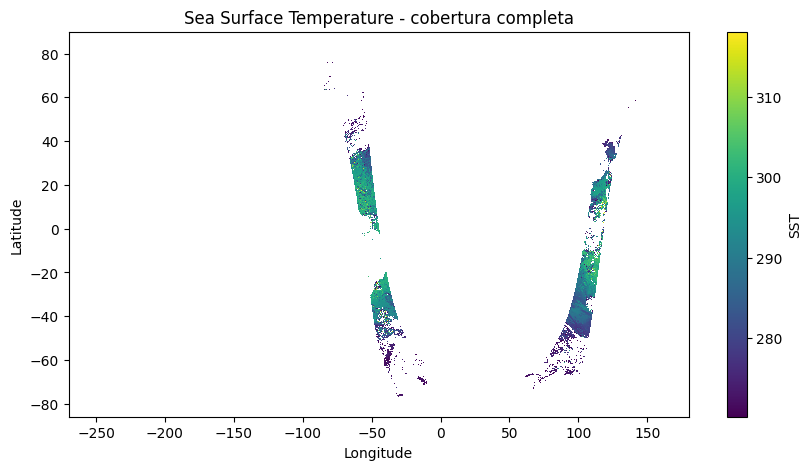

In [ ]:
# 1) carrego o .nc
ds = xr.open_dataset("./Sentinel_3_SST/S3B_SL_2_WST____20250123T010757_20250123T024856_20250124T080407_6059_102_216______MAR_O_NT_003.SEN3/20250123010757-MAR-L2P_GHRSST-SSTskin-SLSTRB-20250124080407-v02.0-fv01.0.nc")

# 2) extraio as coordenadas de longitude e latitude
lon = ds["lon"]
lat = ds["lat"]

# 3) ploto a cobertura completa de sst sem recorte
fig, ax = plt.subplots(figsize=(10, 5))
pcm = ax.pcolormesh(lon, lat, sst, shading="auto")
ax.set_title("Sea Surface Temperature - cobertura completa")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
fig.colorbar(pcm, ax=ax, label="SST")
plt.show()

### Como temos nossa região de estudo e não queremos todo o conteúdo do .nc, é possível reduzir o tamanho antes de gerar o .tif.<br>Portanto, irei "fatiar" variando os valores j0,j1 ; i0 e i1.<br> Esses valores são slices de nj e ni, respectivamente : nj=slice(j0, j1), ni=slice(i0, i1)

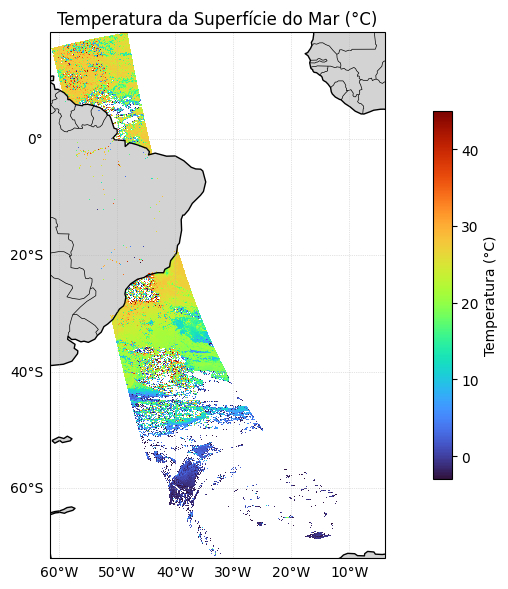

In [ ]:
# caminho do arquivo .nc
nc_path = "./Sentinel_3_SST/S3B_SL_2_WST____20250123T010757_20250123T024856_20250124T080407_6059_102_216______MAR_O_NT_003.SEN3/20250123010757-MAR-L2P_GHRSST-SSTskin-SLSTRB-20250124080407-v02.0-fv01.0.nc"

# abro apenas as variáveis necessárias para reduzir o consumo de memória
with xr.open_dataset(nc_path, chunks={"nj": 1000, "ni": 1000}) as ds:
    # escolha de fatia com dados válidos (reduzindo o tamanho)
    j0, j1 = 2000, 12000  # Reduzido
    i0, i1 = 0, 3000      # Reduzido
    
    # carrego apenas a fatia necessária na memória
    sst = ds["sea_surface_temperature"].isel(time=0, nj=slice(j0, j1), ni=slice(i0, i1)).compute()
    lon = ds["lon"].isel(nj=slice(j0, j1), ni=slice(i0, i1)).compute()
    lat = ds["lat"].isel(nj=slice(j0, j1), ni=slice(i0, i1)).compute()

# aqui, escolhi converter de Kelvin para Celsius, porém recomendo comentar caso queira manter em Kelvin
sst_celsius = sst - 273

# plot com Cartopy
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# insiro um mapa básico (reduzindo a resolução)
ax.coastlines(resolution='110m', color='black')
ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='white')

# adiciono grades
gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.7, linestyle=':')
gl.top_labels = False
gl.right_labels = False

# plotagem do SST em Celsius
pcm = ax.pcolormesh(lon, lat, sst_celsius, transform=ccrs.PlateCarree(), 
                    shading="auto", cmap="turbo")

ax.set_title("Temperatura da Superfície do Mar (°C)") # inserção de título
cbar = fig.colorbar(pcm, ax=ax, label="Temperatura (°C)", orientation="vertical", shrink=0.7) # inseri uma barra de cores para representar a temperatura

plt.tight_layout()
plt.show()

## É possível criar um .nc apenas com o recorte feito (conforme plot acima), além de converter Kelvin para Celsius

In [ ]:
import xarray as xr

# caminho do arquivo .nc original
nc_path = "./Sentinel_3_SST/S3B_SL_2_WST____20250123T010757_20250123T024856_20250124T080407_6059_102_216______MAR_O_NT_003.SEN3/20250123010757-MAR-L2P_GHRSST-SSTskin-SLSTRB-20250124080407-v02.0-fv01.0.nc"

# caminho para o .nc após recorte
output_path = "final_vf_.nc"

# mantenho a mesma fatia com dados válidos que defini anteriormente no plot
j0, j1 = 2000, 12000 
i0, i1 = 0, 3000 

# abro o dataset
ds = xr.open_dataset(nc_path, decode_cf=True) # me certifico de que decode_df seja True para que ele converta valores de temperatura, trate FillValue com NaN, ajuste calendários e padronize eixos (renomeia dimensões para lat/lon)

# recorto apenas a região de interesse
ds_recortado = ds.isel(time=slice(0,1), nj=slice(j0, j1), ni=slice(i0, i1))  # slice(start, stop)

# obtenho a variável de temperatura da superfície do mar
sst = ds_recortado.sea_surface_temperature

# converto de Kelvin para Celsius
sst_c = sst - 273.15

# crio um novo dataset com os dados em Celsius, mantendo as coordenadas e atributos
ds_celsius = ds_recortado.copy()
ds_celsius['sea_surface_temperature'] = sst_c

# adiciono um atributo indicando que a unidade agora é Celsius
ds_celsius.sea_surface_temperature.attrs['units'] = 'Celsius'
ds_celsius.sea_surface_temperature.attrs['long_name'] = 'Sea Surface Temperature in Celsius'

# salvo o resultado para um novo arquivo NetCDF
ds_celsius.to_netcdf(output_path)

# fecho os datasets para liberar memória
ds.close()
ds_recortado.close()
ds_celsius.close()

print(f"Arquivo recortado e convertido para Celsius salvo em: {output_path}")

/work/projetos/projeto-sophia-agro/.venv/lib/python3.8/site-packages/xarray/coding/times.py:613: RuntimeWarning: invalid value encountered in cast
  int_num = np.asarray(num, dtype=np.int64)


Arquivo recortado e convertido para Celsius salvo em: /work/projetos/projeto-sophia-agro/sentinel2_10m/Sentinel_3_SST/final_vf_.nc


## Agora que o .nc foi recortado e convertido para Celsius, posso exportar como .tif e visualizar no QGIS

In [ ]:
import subprocess 

# defino os caminhos de leitura e download em formato .tif
input_nc = "final_vf_.nc"
output_tif = "sst.tif"

# executo o gdalwarp
cmd = [
    "gdalwarp",
    "-geoloc",
    f"NETCDF:{input_nc}:sea_surface_temperature",
    output_tif
]

# observação: o processo pode ser feito no terminal com o comando:
# gdalwarp -geoloc NETCDF:sst_recortado_celsius.nc:sea_surface_temperature sst.tif
# comando base: 
# gdalwarp -geoloc NETCDF:"seuarquivo".nc:sea_surface_temperature "formato".tif

subprocess.run(cmd, check=True)
print(f"Arquivo salvo em: {output_tif}")

# observação: as mensagens de Warning são comuns. Assistir vídeo no minuto 20:30 que explica esse passo a passo gerado acima:
# https://www.youtube.com/watch?v=XqoetylQAIY

Warning 1: dimension #2 (ni) is not a Longitude/X dimension.
Warning 1: dimension #1 (nj) is not a Latitude/Y dimension.
Warning 1: dimension #1 (ni) is not a Longitude/X dimension.
Warning 1: dimension #0 (nj) is not a Latitude/Y dimension.
Warning 1: dimension #1 (ni) is not a Longitude/X dimension.
Warning 1: dimension #0 (nj) is not a Latitude/Y dimension.


Creating output file that is 6369P x 10029L.
Processing NETCDF:/work/projetos/projeto-sophia-agro/sentinel2_10m/Sentinel_3_SST/final_vf_.nc:sea_surface_temperature [1/1] : 0Using internal nodata values (e.g. nan) for image NETCDF:/work/projetos/projeto-sophia-agro/sentinel2_10m/Sentinel_3_SST/final_vf_.nc:sea_surface_temperature.
Copying nodata values from source NETCDF:/work/projetos/projeto-sophia-agro/sentinel2_10m/Sentinel_3_SST/final_vf_.nc:sea_surface_temperature to destination final_esse_.tif.
...

ERROR 1: Too many points (529 out of 529) failed to transform, unable to compute output bounds.
Warning 1: Unable to compute source region for output window 3184,0,3185,5014, skipping.
ERROR 1: Too many points (529 out of 529) failed to transform, unable to compute output bounds.
Warning 1: Unable to compute source region for output window 0,7521,1592,2508, skipping.
ERROR 1: Too many points (529 out of 529) failed to transform, unable to compute output bounds.
Warning 1: Unable to compute source region for output window 4776,5014,1593,2507, skipping.


10...20...30...40...50...60...70...80...90...100 - done.
Arquivo salvo em: final_esse_.tif
